## Creating objects for oscilloscope and Creación de objetos osciloscopio y rotating base

In [3]:
from osctck import *
from rotmcESP import *
from utils import *
import matplotlib.pyplot as plt
from tqdm import tqdm

TDS2024 = Osctck('USB0::1689::874::C034414::0::INSTR')
ESP300 = RotmcESP('ASRL/dev/ttyUSB0::INSTR')

## Instruments configuration

In [4]:
TDS2024.config(channels = (1,),
                 triggerSource = 'EXT',
                 triggerLevel = 0.5,
                 triggerSlope = 'RISE',
                 triggerMode = 'NORM',
                 triggerCoup = 'AC',
                 acquisition = 16,
                 vAutoScale = True)

ESP300.config(axis = 2,
              vel = 2,
              direction = '+',
              setOrigin = True)

TypeError: Osctck.config() missing 2 required positional arguments: 'chanband' and 'chaninv'

## Seting and starting measurement

In [3]:
# Parámetros de rotación
initAng = 0
endAng = 360
angleStep = 10
currPostion = initAng
arco = endAng-initAng

# Variables de guardado de datos
Rto = 112.50e3 # [ohm]
Rs = 42.625e-3 # [m] # distancia entre el transductor y el centro del eje de rotación
Fl = 13/(np.pi*(1.2/2)**2) # [mJ/cm2]
tmed = 35e-6 # [s]
timebase=2.5e-6 #seconds per division
Navg = 16
sample = 'logan_6x4p5mm'

ltMeas = []
ltAng = []
filePath = getFilePath()

# Comienzo de ciclo de medición
for i in tqdm(range(initAng, endAng, angleStep)):
    # print("\nRealizando medición a {0}°...".format(currPostion))
    meas = TDS2024()
    ltAng.append(currPostion)
    ltMeas.append(meas[1])
    # plt.plot(meas[0] * 1e6, meas[1]), plt.xlabel("Time [μs]"), plt.ylabel("Amplitude [V]"), plt.show()
    currPostion = ESP300(reference = 'REL', rotAngle = angleStep)

# Guardado de datos
sinogram = np.array([np.array(i) for i in ltMeas])
t = meas[0]
angles = np.array(ltAng)
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, arco=arco)
print(angles.shape),print(angles)


Ingrese el nombre del archivo en el que guardar resultados:  med20oct23_7


100%|███████████████████████████████████████████| 36/36 [11:24<00:00, 19.03s/it]

(36,)
['0' '9.99' '19.98' '29.96' '39.95' '49.94' '59.90' '69.89' '79.88'
 '89.87' '99.86' '99.86' '109.87' '119.83' '129.81' '139.78' '149.76'
 '159.75' '169.74' '179.70' '189.69' '199.67' '209.66' '219.65' '229.65'
 '239.63' '249.62' '259.61' '269.57' '279.54' '289.53' '299.51' '309.49'
 '319.47' '329.46' '339.44']


(None, None)

## Image reconstruction using classical approaches

In [4]:
# Obtaining the speed of sound

A = 0.1662
B = 3969.36
Rtf = 112.65e3
Tmed = T_estimate(A, B, Rto) # Initial value
Tmedf = T_estimate(A, B, Rtf) #final value!
vsmed = vela9mac(Tmed)
vsmedf = vela9mac(Tmedf)
print("Temperatura inicial: {0:0.2f} °C".format(Tmed))
print("Velocidad del sonido inicial: {0:0.2f} m/s".format(vsmed))
print("Temperatura final: {0:0.2f} °C".format(Tmedf))
print("Velocidad del sonido final: {0:0.2f} m/s".format(vsmedf))

Temperatura inicial: 22.51 °C
Velocidad del sonido inicial: 1489.32 m/s
Temperatura final: 22.48 °C
Velocidad del sonido final: 1489.24 m/s


In [53]:
loadmea = False
#filename = 'Mediciones/Mediciones 10-10-2023/med10oct23_3.npz'
if loadmea:
    import numpy as np
    from utils import *
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    
    data = np.load(filename)
    t=data['t']; sinogram=data['sinogram']; angles=data['angles']; Rto=data['Rto']; arco=data['arco']
    Rs=data['Rs']; Fl=data['Fl']; Navg=data['Navg']; sample=data['sample']; vs=data['vs']
else:
    vs = vsmed*0.9680

In [54]:
from OAT import applyDAS, applyUBP

# Measurements parameters
Ns, Nt = sinogram.shape
to = t[0]
tf = t[-1]
nx = 128
dx = 110e-6
p = -1*sinogram
dsa = Rs#*1.03 #-------------------> Error del 3% en la distancia???
fmax = 4e6

Xdas = applyDAS(Ns,Nt,dx,nx,dsa,arco,vs,to,tf,p*1)
#Xubp = applyUBP(Ns,Nt,dx,nx,dsa,arco,vs,to,tf,p,fmax)

## Results: logan_6x4p5mm: med20oct23_7 (T = 25 us) 36 angles

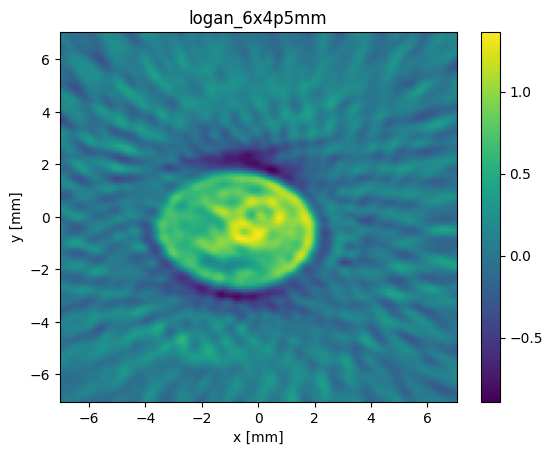

In [55]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

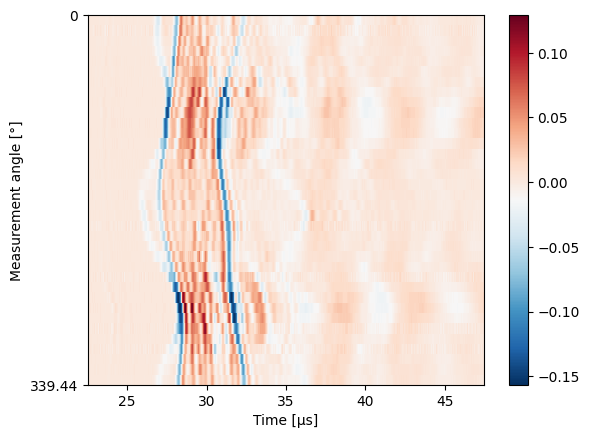

In [56]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

In [57]:
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rtf=Rtf, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

## Results: venas_14x12mm: med20oct23_6 (T = 25 us) 36 angles

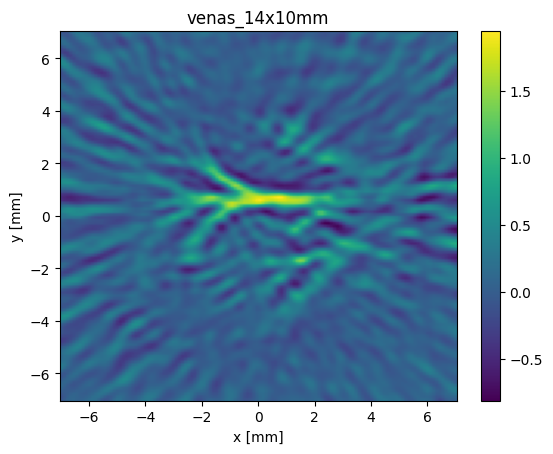

In [48]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

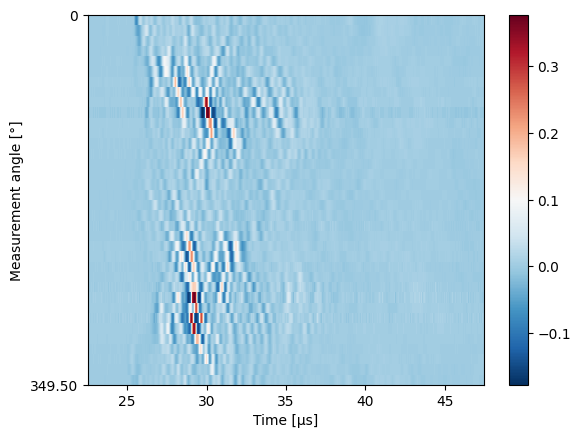

In [49]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

In [50]:
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rtf=Rtf, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

## Results: venas_5p5x5p5mm: med20oct23_5 (T = 25 us) 180 angles

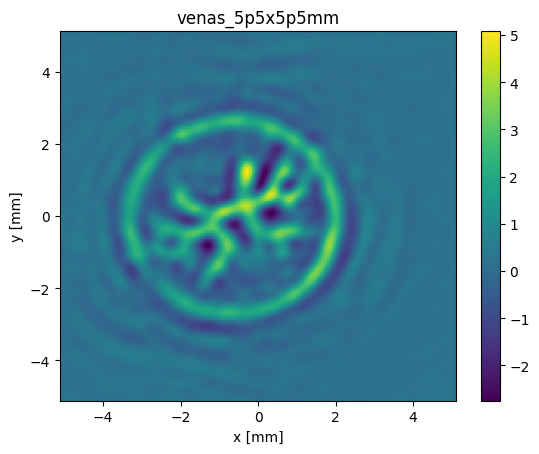

In [32]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

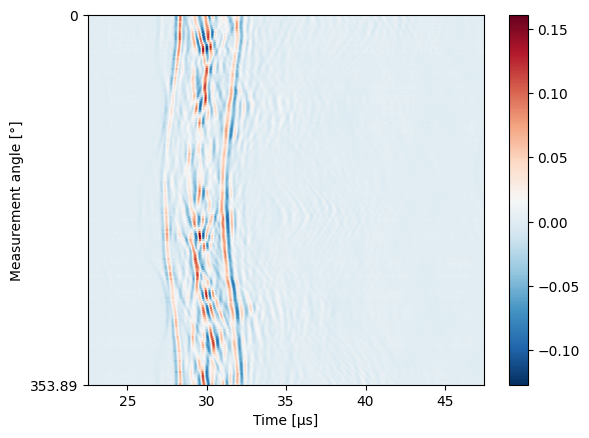

In [39]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

In [40]:
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rtf=Rtf, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

## Results: venas_5p5x5p5mm: med20oct23_4 (T = 25 us) 36 angles

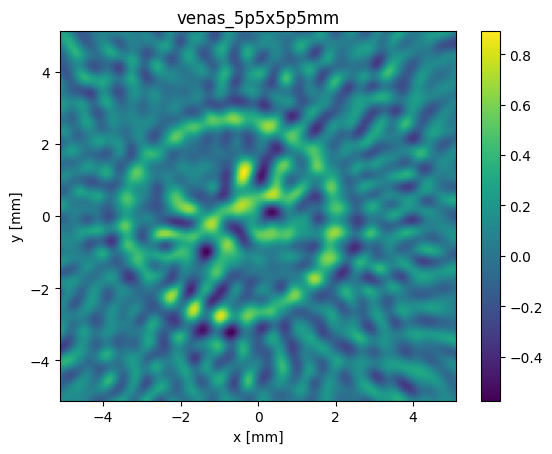

In [13]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

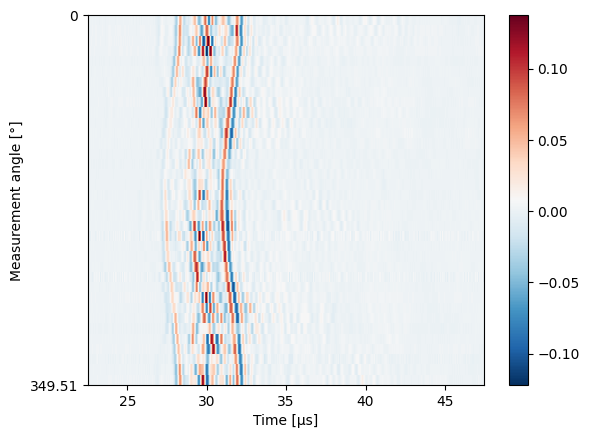

In [23]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

In [24]:
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rtf=Rtf, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

## Results: disco_3x3mm: med20oct23_3 (T = 25 us) 36 angles

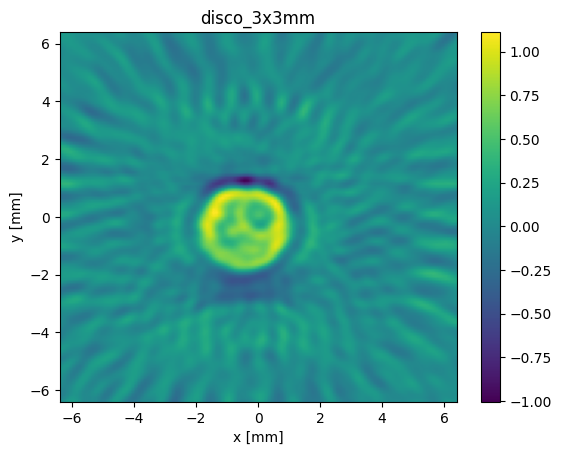

In [31]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

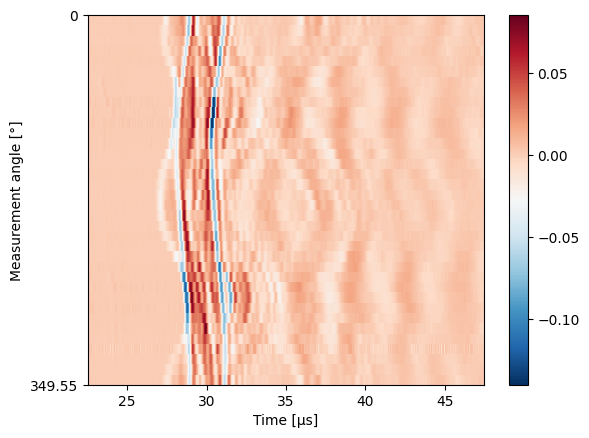

In [32]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

In [33]:
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rtf=Rtf, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

## Results: elipse_3x4mm: med20oct23_2 (T = 25 us) 36 angles

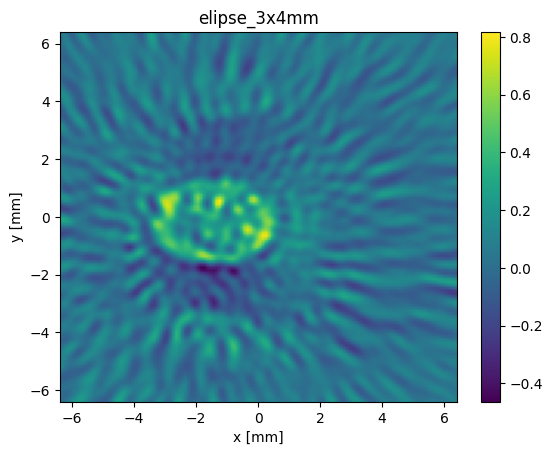

In [16]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

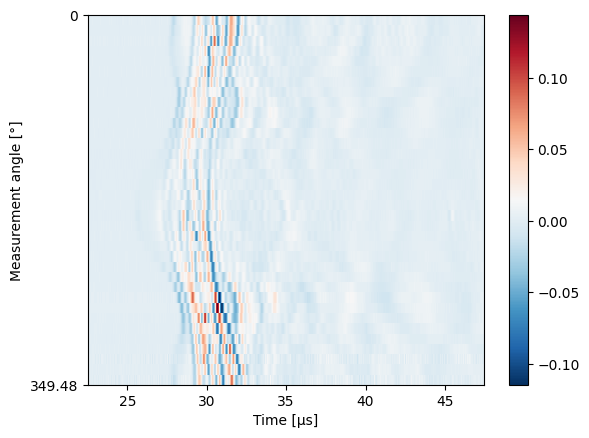

In [18]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

In [17]:
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rtf=Rtf, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

## Results: elipse_3x4mm: med20oct23_1 (T = 25 us) 36 angles

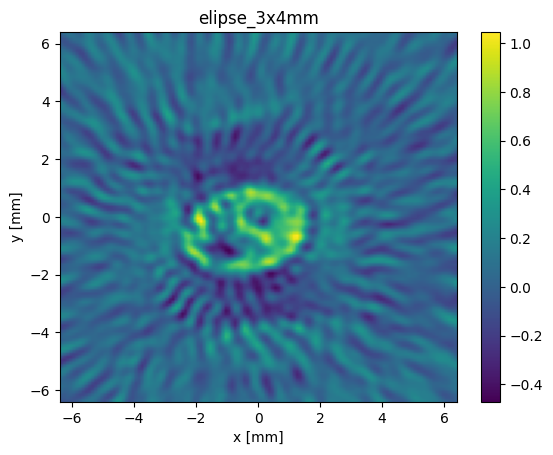

In [68]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

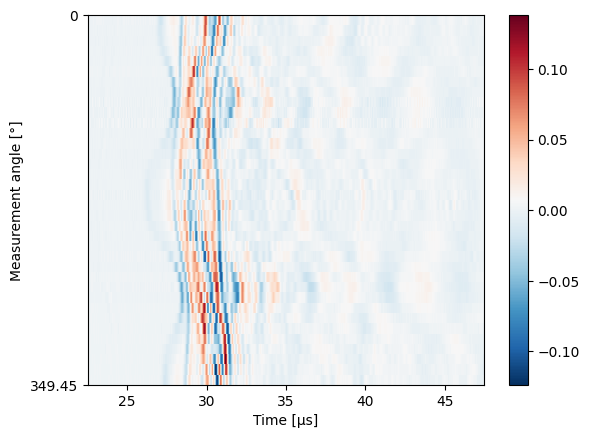

In [54]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

In [69]:
vs = vsmed*0.9705
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rtf=Rtf, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

## Results: pelos de 8 mm x 100 +/- 10 um: med12oct23_7 (T = 25 us) 36 angles

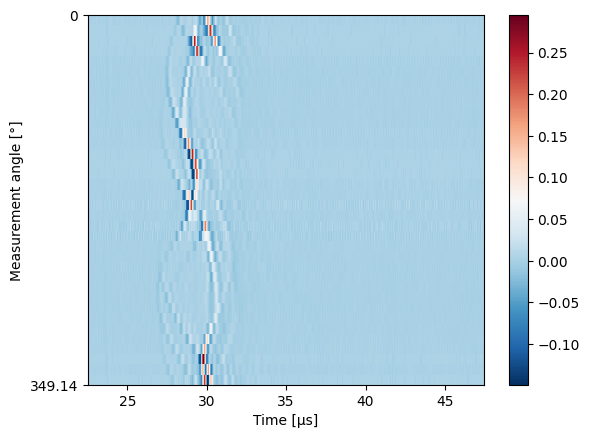

In [44]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

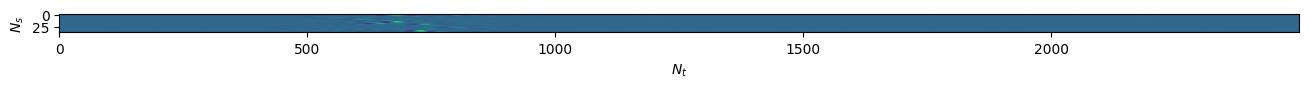

In [45]:
plt.figure(figsize=(16,8))
plt.imshow(-1*sinogram)
plt.xlabel("$N_t$")
plt.ylabel("$N_s$")
plt.show()

In [46]:
vs = vsmed*0.9705
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

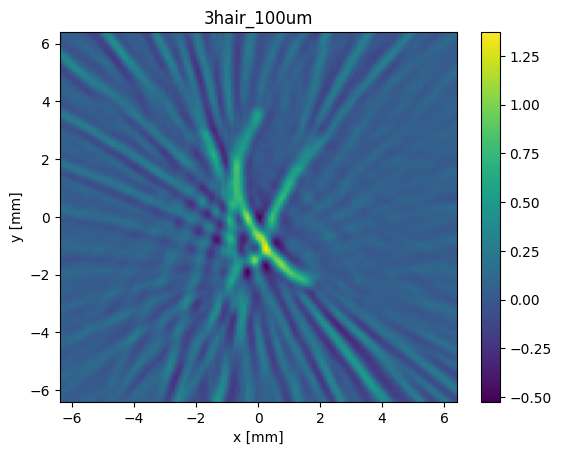

In [47]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

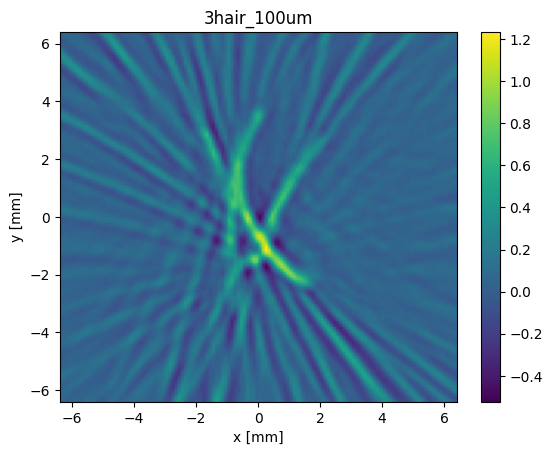

In [34]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

## Results: venas 5x5 mm2 sample: med12oct23_6 (T = 25 us) 36 angles

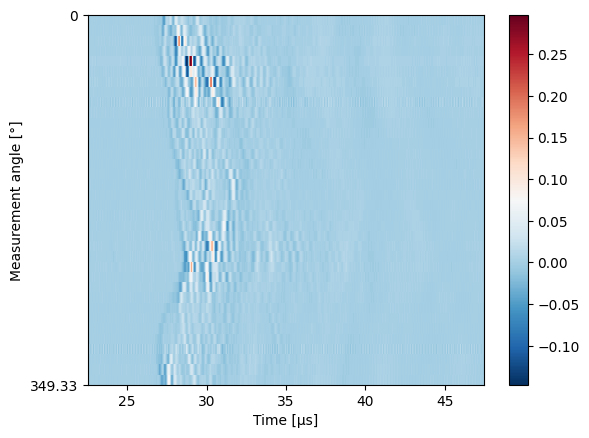

In [20]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

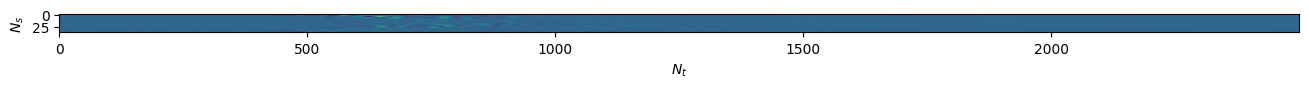

In [21]:
plt.figure(figsize=(16,8))
plt.imshow(-1*sinogram)
plt.xlabel("$N_t$")
plt.ylabel("$N_s$")
plt.show()

In [22]:
vs = vsmed*0.969
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

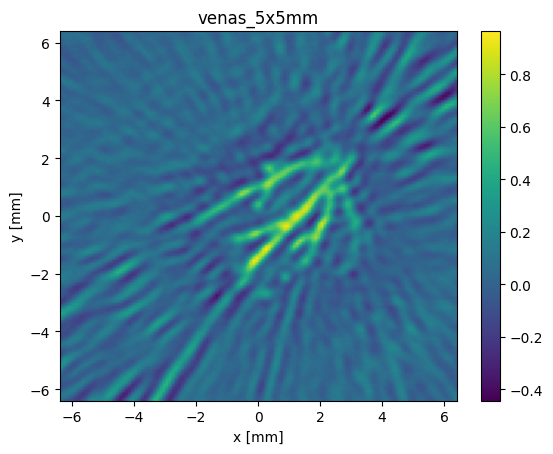

In [23]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

## Results: venas 5x5 mm2 sample: med12oct23_5 (T = 25 us) 180 angles

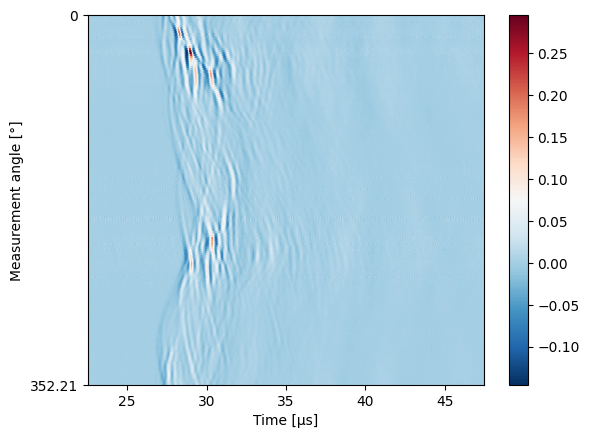

In [25]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

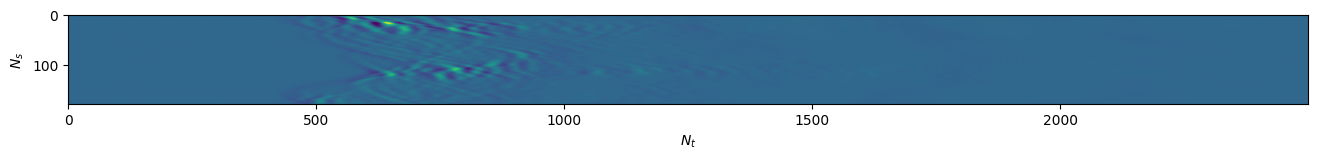

In [26]:
plt.figure(figsize=(16,8))
plt.imshow(-1*sinogram)
plt.xlabel("$N_t$")
plt.ylabel("$N_s$")
plt.show()

In [27]:
vs = vsmed*0.969
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

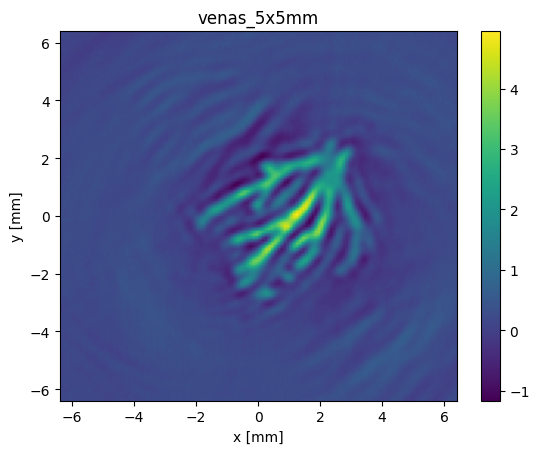

In [28]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

## Results: UBA 4x4 mm2 sample: med12oct23_4 (T = 25 us) Angles x 2

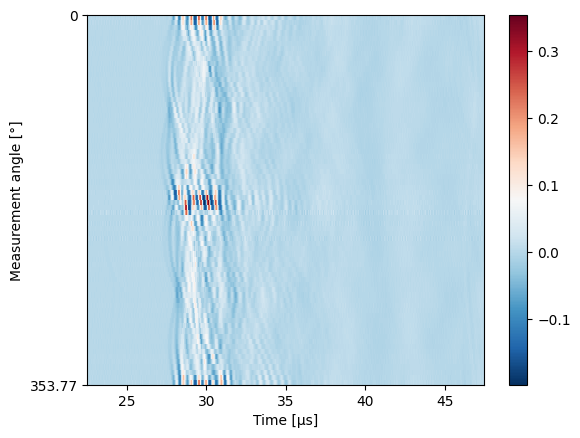

In [21]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

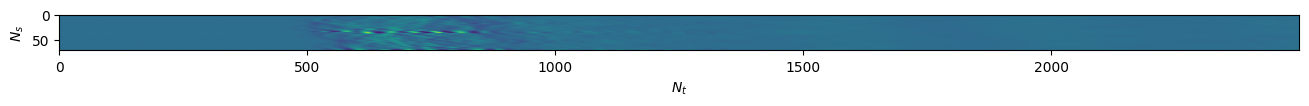

In [22]:
plt.figure(figsize=(16,8))
plt.imshow(-1*sinogram)
plt.xlabel("$N_t$")
plt.ylabel("$N_s$")
plt.show()

In [23]:
vs = vsmed*0.968
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

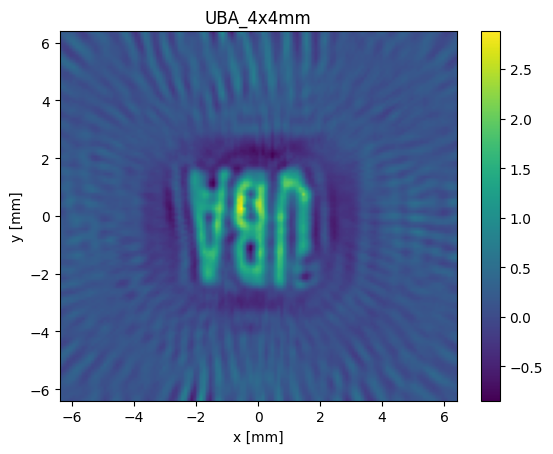

In [24]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

## Results: UBA 4x4 mm2 sample: med12oct23_3 (T = 25 us)

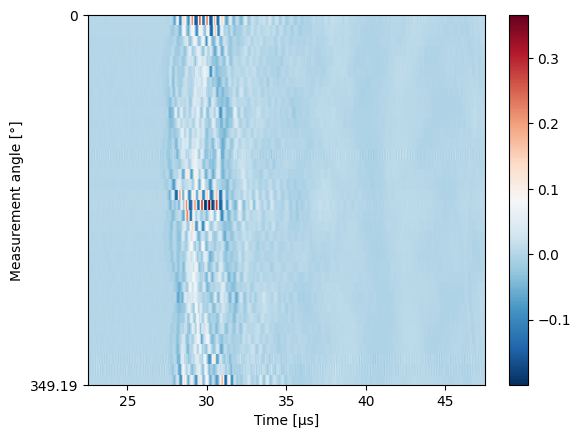

In [7]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

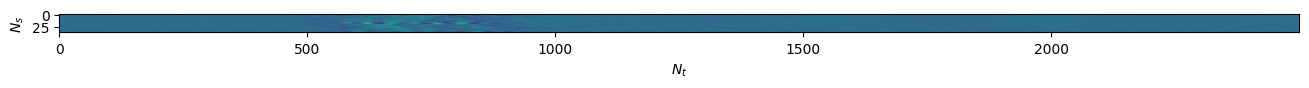

In [18]:
plt.figure(figsize=(16,8))
plt.imshow(-1*sinogram)
plt.xlabel("$N_t$")
plt.ylabel("$N_s$")
plt.show()

In [19]:
vs = vsmed*0.9675
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

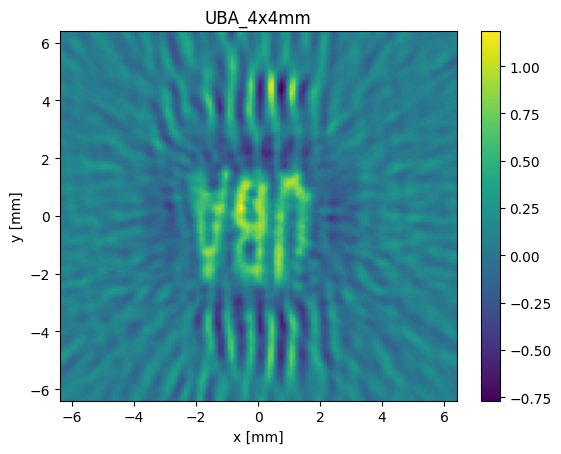

In [17]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

## Results: UBA 4x4 mm2 sample: med12oct23_2 (T = 50 us)

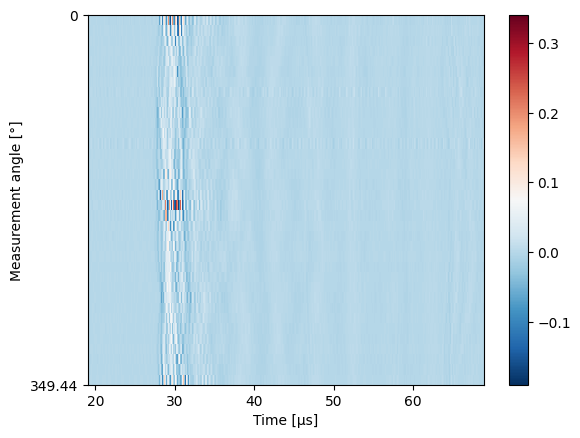

In [21]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

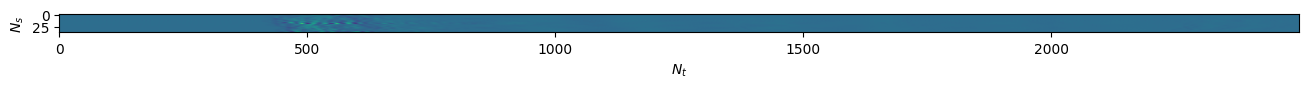

In [22]:
plt.figure(figsize=(16,8))
plt.imshow(-1*sinogram)
plt.xlabel("$N_t$")
plt.ylabel("$N_s$")
plt.show()

In [23]:
vs = vsmed*0.9675
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

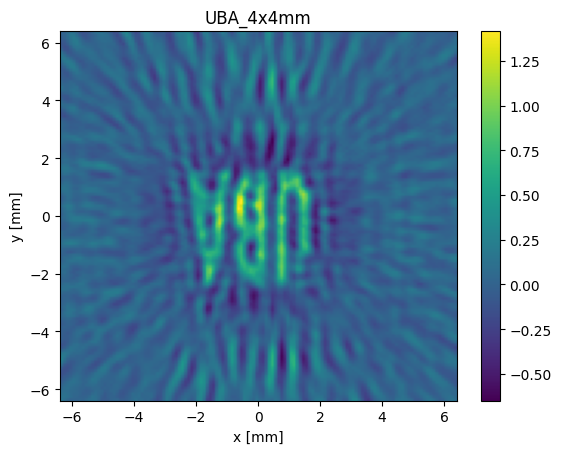

In [20]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

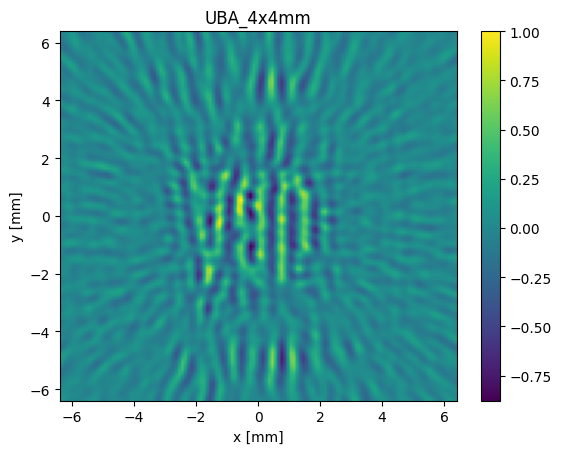

In [24]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xubp,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

## Results: OA 4x4 mm2 sample: med12oct23_1 (T = 50 us)

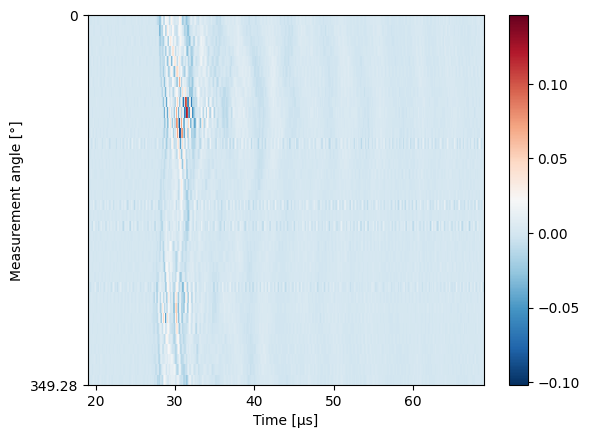

In [45]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

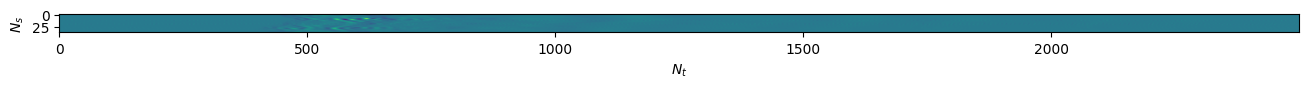

In [46]:
plt.figure(figsize=(16,8))
plt.imshow(-1*sinogram)
plt.xlabel("$N_t$")
plt.ylabel("$N_s$")
plt.show()

In [44]:
vs = vsmed*0.965
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

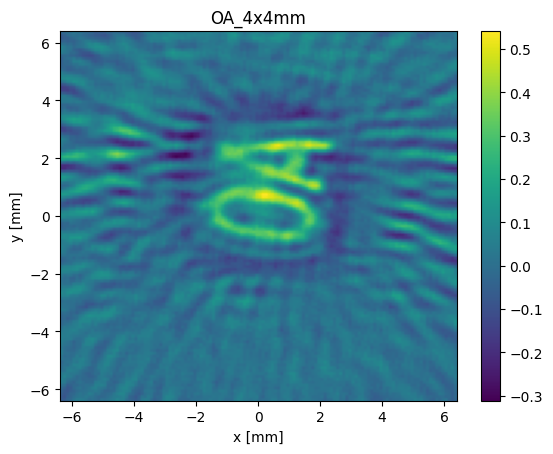

In [40]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

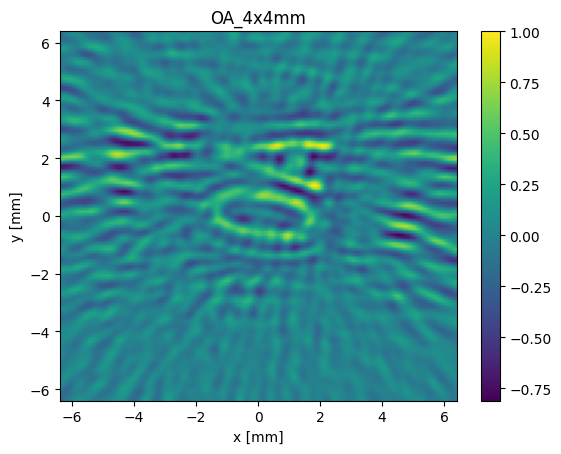

In [41]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xubp,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

## Results: OB 4x4 mm2 sample: med10oct23_3 (T = 50 us)

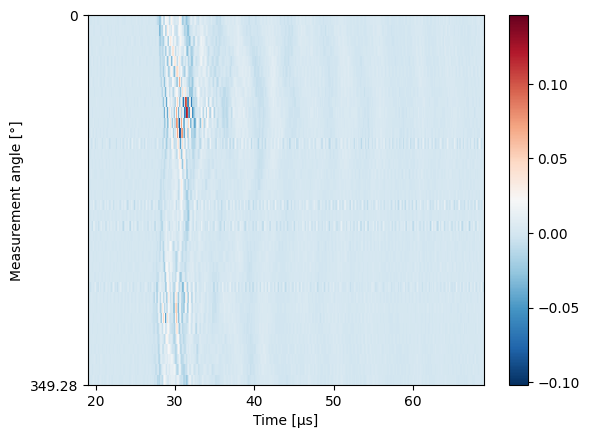

In [5]:
axis_ticks = [t[0]*1e6, t[-1]*1e6, angles[-1], angles[0]]
plt.imshow(-1*sinogram, cmap="RdBu_r", interpolation="nearest",extent=axis_ticks, aspect="auto")
plt.xlabel("Time [μs]")
plt.ylabel("Measurement angle [°]")
plt.colorbar()
plt.show()

In [15]:
vs = vsmed*0.975
np.savez(filePath + '.npz', t=t, sinogram=sinogram, angles=angles, Rto=Rto, Rs=Rs, Fl=Fl, Navg=Navg, sample = sample, vs=vs, arco = arco)

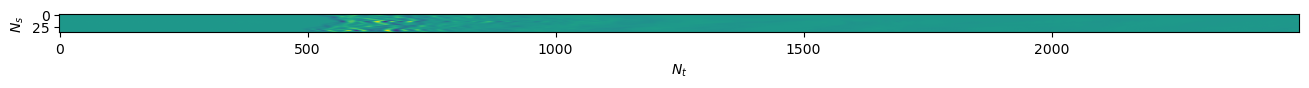

In [12]:
plt.figure(figsize=(16,8))
plt.imshow(-1*sinogram)
plt.xlabel("$N_t$")
plt.ylabel("$N_s$")
plt.show()

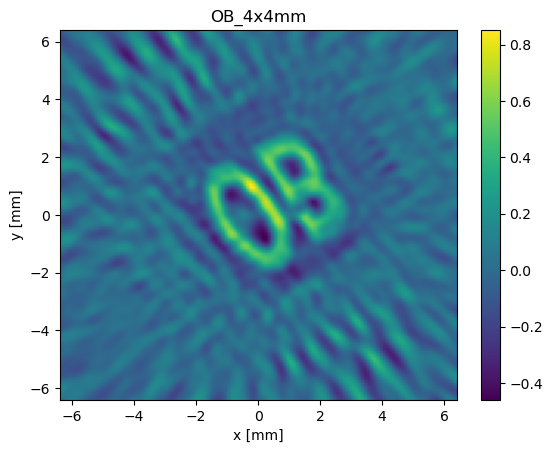

In [3]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xdas,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()

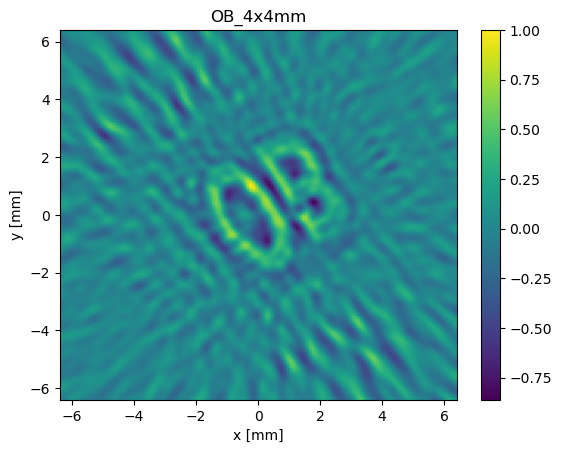

In [4]:
axis_ticks = [-nx*dx*1e3/2, nx*dx*1e3/2, -nx*dx*1e3/2, nx*dx*1e3/2]
plt.figure(),plt.imshow(np.reshape(Xubp,(nx,nx)),extent=axis_ticks, aspect="auto")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.title(sample)
plt.colorbar()